In [1]:
from __future__ import absolute_import, division, print_function

import sys
import os
import time

sys.path.insert(0,'../../')
sys.path.insert(0,'../../../py')

import parameters
import utilities
import spectrogram_utilities
import output_utilities
import spectrogram_output_visualiser
import spectrogram_cuts_db_creation

import numpy as np
import pandas as pd
import h5py

import tensorflow as tf

from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier



from scipy import signal
from sklearn import preprocessing, metrics
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# matplotlib.get_backend()
%matplotlib inline

# constants
awd_event = 1
site = parameters.sites[0]

# use gpu
from keras import backend as K
print('GPUs:',K.tensorflow_backend._get_available_gpus())
gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))


Using TensorFlow backend.


GPUs: ['/job:localhost/replica:0/task:0/device:GPU:0']


## Database

### Loading H5 files

In [2]:
# load dataset from every site
training_set_1 = 'training_set_'+site+'.h5'
training_set_2 = 'training_set_'+site+'_augmented.h5'

data, pb, evt, f_cut_length, t_cut_length = spectrogram_cuts_db_creation.load_spectrogram_cuts_db(awd_event, site, training_set_1 , verbose=True, noise=True)
_data, pb, _evt, f_cut_length, t_cut_length = spectrogram_cuts_db_creation.load_spectrogram_cuts_db(awd_event, site, training_set_2 , verbose=True, noise=True)

data = np.append(data, _data, axis=0)
evt = np.append(evt, _evt, axis=0)

_data =0
_evt = 0


Loading spectrogram cuts from database for awdEvent1/marion
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........
Runtime: 17.94 seconds

Loading spectrogram cuts from database for awdEvent1/marion
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........
Runtime: 64.52 seconds


In [3]:
print(data.shape, evt.shape)

# suffle data
data = list(zip(data,evt))
np.random.seed(7)
np.random.shuffle(data)
np.random.seed(23)
np.random.shuffle(data)
data, evt = zip(*data)
data = np.array(data)
evt = np.array(evt)

# scale data
scaler = preprocessing.StandardScaler().fit(data)
data = scaler.transform(data)

# reshpa for CNN
data = data.reshape((len(data),parameters.clf_input_depth,
              parameters.clf_input_width,
              parameters.clf_input_height))
evt = np_utils.to_categorical(evt)
print(data.shape, evt.shape)

(80085, 16384) (80085,)
(80085, 1, 128, 128) (80085, 2)


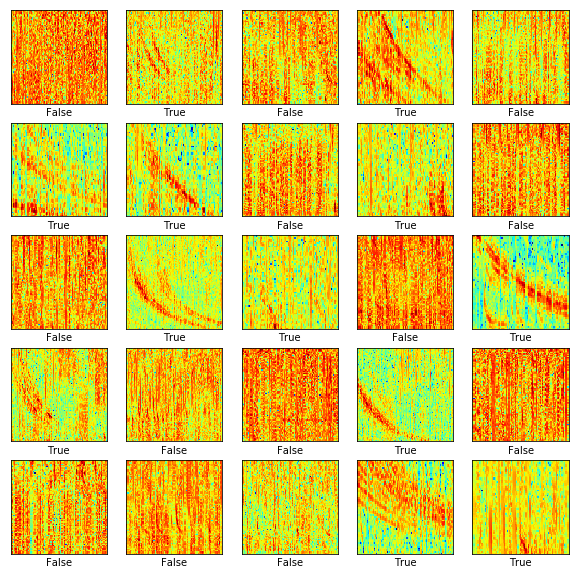

In [5]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    k = np.random.randint(len(data))
    plt.pcolormesh(data[k][0], cmap='jet')
    plt.xlabel(np.bool_(evt[k][1]))
plt.show()

In [6]:
def create_model():
    # create the model
    model = Sequential()
    model.add(Conv2D(32,(3,3), input_shape=(parameters.clf_input_depth,parameters.clf_input_width, parameters.clf_input_height),
                    padding='same', activation='relu',data_format='channels_first'))
    model.add(Dropout(0.2))
    model.add(Conv2D(16, (3,3), activation='relu', padding='same',data_format='channels_first'))
    model.add(MaxPooling2D(pool_size=(2,2),data_format='channels_first'))
#     model.add(Conv2D(16, (3,3), activation='relu', padding='same',data_format='channels_first'))
#     model.add(Conv2D(4, (3,3), activation='relu', padding='same',data_format='channels_first'))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    # compile model
    epochs = 25
    lrate = 0.01
    decay = lrate/epochs
    sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
    adam = Adam(lr=lrate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay, amsgrad=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    print(model.summary())
    return model
# model = KerasClassifier(build_fn=create_model)
model = create_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 128, 128)      320       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 128, 128)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 128, 128)      4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 64, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_1 (Dense)      

Instructions for updating:
Use tf.cast instead.
Train on 53656 samples, validate on 26429 samples
Epoch 1/25
53656/53656 [==============================] - 141s 3ms/step - loss: 0.0903 - acc: 0.9647 - val_loss: 0.0161 - val_acc: 0.9948
Epoch 2/25
53656/53656 [==============================] - 71s 1ms/step - loss: 0.0117 - acc: 0.9965 - val_loss: 0.0101 - val_acc: 0.9969
Epoch 3/25
53656/53656 [==============================] - 71s 1ms/step - loss: 0.0050 - acc: 0.9984 - val_loss: 0.0089 - val_acc: 0.9976
Epoch 4/25
53656/53656 [==============================] - 71s 1ms/step - loss: 0.0023 - acc: 0.9994 - val_loss: 0.0093 - val_acc: 0.9974
Epoch 5/25
53656/53656 [==============================] - 71s 1ms/step - loss: 0.0016 - acc: 0.9996 - val_loss: 0.0090 - val_acc: 0.9971
Epoch 6/25
53656/53656 [==============================] - 71s 1ms/step - loss: 0.0012 - acc: 0.9996 - val_loss: 0.0089 - val_acc: 0.9978
Epoch 7/25
53656/53656 [==============================] - 71s 1ms/step - loss: 

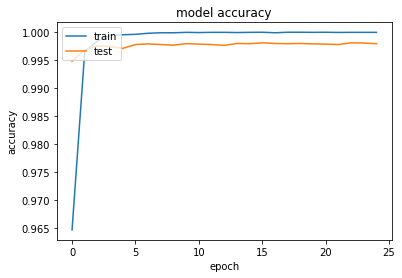

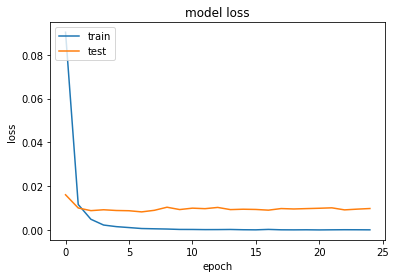

In [7]:
history = model.fit(data, evt, validation_split=0.33, epochs=25, batch_size=100)

print(history.history.keys())
# summarize history for accuracy
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

model.save('cnn_culmul.h5')

In [8]:
# load dataset from every site
testing_set_1 = 'testing_set_'+site+'.h5'
testing_set_2 = 'testing_set_'+site+'_augmented.h5'

data, pb, evt, f_cut_length, t_cut_length = spectrogram_cuts_db_creation.load_spectrogram_cuts_db(awd_event, site, testing_set_1 , verbose=True, noise=True)
_data, pb, _evt, f_cut_length, t_cut_length = spectrogram_cuts_db_creation.load_spectrogram_cuts_db(awd_event, site, testing_set_2 , verbose=True, noise=True)

data = np.append(data, _data, axis=0)
evt = np.append(evt, _evt, axis=0)

_data =0
_evt = 0

data = scaler.transform(data)

data = data.reshape((len(data),parameters.clf_input_depth,
              parameters.clf_input_width,
              parameters.clf_input_height))

evt = np_utils.to_categorical(evt)

pred = model.predict(data, batch_size=50)
print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(evt.argmax(axis=-1), pred.argmax(axis=-1))))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(evt.argmax(axis=-1), pred.argmax(axis=-1)))


Loading spectrogram cuts from database for awdEvent1/marion
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........
Runtime: 97.81 seconds

Loading spectrogram cuts from database for awdEvent1/marion
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........
Runtime: 111.55 seconds
Classification report for classifier <keras.engine.sequential.Sequential object at 0x7f1424202588>:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22745
           1       1.00      0.99      1.00     16548

    accuracy                           1.00     39293
   macro avg       1.00      1.00      1.00     39293
weighted avg       1.00      1.00      1.00     39293


Confusion matrix:
[[22714    31]
 [   84 16464]]


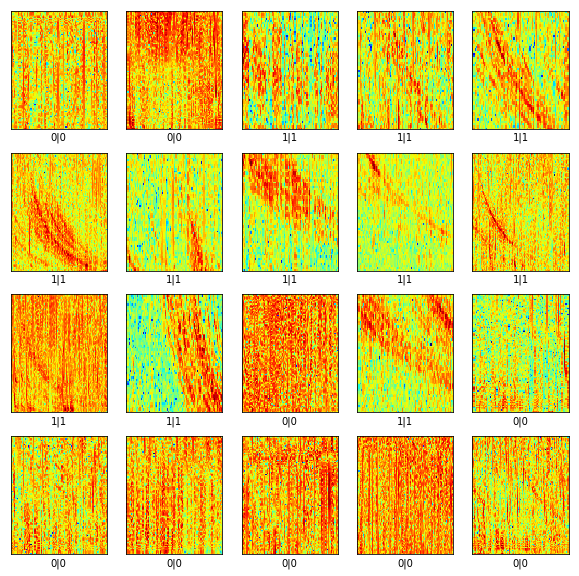

In [10]:
plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    k = np.random.randint(len(data))
    plt.pcolormesh(data[k][0], cmap='jet')
    plt.xlabel(str(pred[k].argmax(axis=-1))+'|'+str(evt[k].argmax(axis=-1)))
plt.show()
# pred = np.argmax(predictions, axis=1)

# print("Classification report for classifier %s:\n%s\n"
#       % (model, metrics.classification_report(evt, pred)))
# print("Confusion matrix:\n%s" % metrics.confusion_matrix(evt, pred))

In [13]:
print(pred[:10])
print(evt[:10])

[0 0 0 0 0 0 0 0 0 0]
[ True  True False False False  True  True  True  True False]
